In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import rcParams
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

# Set the global font to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# Set global font scale
sns.set_theme(font_scale=1.2)  # Adjust the number as needed (e.g., 1.2 for 20% larger fonts)

In [99]:
df_metrics = pd.read_csv("output/df_metric_momentum_wresults.csv")
df_metrics.columns

Index(['Combination', 'Perplexity', 'Early_exaggeration', 'Initial_momentum',
       'Final_momentum', 'Theta', 'tSNE_runtime_min', 'KL_divergence',
       'trust_k30', 'trust_k300', 'stress'],
      dtype='object')

In [3]:
parameters = ['Perplexity', 'Early_exaggeration', 'Initial_momentum', 'Final_momentum', 'Theta']

In [100]:
def analyze_quality_with_random_forest_3bins(df_input, parameters, quality_metric, n_tree=100):
    # Convert the quality metric into discrete categories
    df = df_input
    df['quality'] = pd.cut(df[quality_metric], bins=3, labels=['low', 'medium', 'high'])
    
    binned_params = pd.DataFrame()
    for param in parameters:
        binned_params[param] = pd.cut(df[param], bins=3, labels=['low', 'medium', 'high'])
    
    # One-hot encode the binned parameters
    encoder = OneHotEncoder(sparse_output=False)
    X_encoded = encoder.fit_transform(binned_params)
    
    # Convert to a DataFrame with appropriate column names
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(parameters))
    
    # Define features and labels
    X = X_encoded
    y = df['quality']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_tree, random_state=42)
    clf.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = clf.predict(X_test)
    print(f"Classification report for {quality_metric}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=['low', 'medium', 'high'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {quality_metric}')
    plt.show()
    
    # Extract and print the decision rules from one tree in the forest
    print(f"Decision rules from one tree in the Random Forest for {quality_metric}:\n")
    tree = clf.estimators_[0]
    tree_rules = export_text(tree, feature_names=list(X.columns)).split('\n')
    for rule in tree_rules:
        print(rule)
    
    # Plot the same decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=X.columns, class_names=['low', 'medium', 'high'], filled=True)
    plt.title(f'Decision Tree from the Random Forest for {quality_metric}')
    plt.show()

Classification report for KL_divergence:

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         1
         low       0.85      0.90      0.87        80
      medium       0.43      0.33      0.38        18

    accuracy                           0.79        99
   macro avg       0.43      0.41      0.42        99
weighted avg       0.76      0.79      0.77        99



C:\Users\luana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\luana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\luana\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


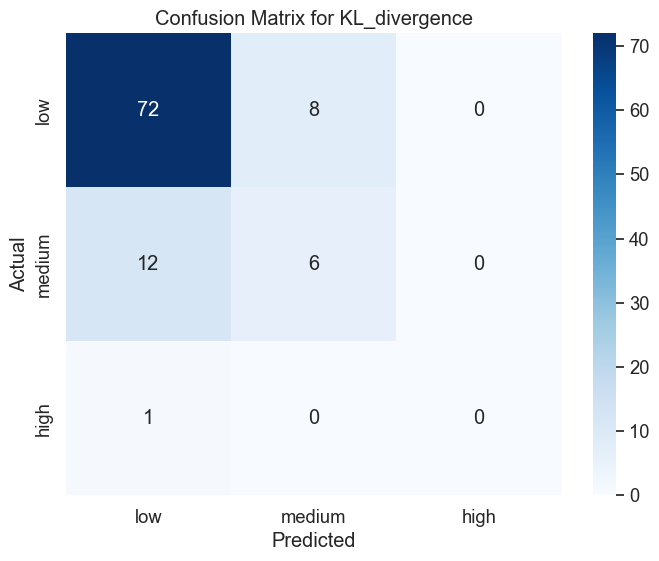

Decision rules from one tree in the Random Forest for KL_divergence:

|--- Theta_high <= 0.50
|   |--- Perplexity_low <= 0.50
|   |   |--- Early_exaggeration_low <= 0.50
|   |   |   |--- Final_momentum_high <= 0.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- Final_momentum_high >  0.50
|   |   |   |   |--- Perplexity_medium <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Perplexity_medium >  0.50
|   |   |   |   |   |--- Initial_momentum_medium <= 0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Initial_momentum_medium >  0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |--- Early_exaggeration_low >  0.50
|   |   |   |--- Perplexity_medium <= 0.50
|   |   |   |   |--- Final_momentum_low <= 0.50
|   |   |   |   |   |--- Final_momentum_high <= 0.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Final_momentum_high >  0.50
|   |   |   |   |   |   |--- Theta_medium <= 0.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |

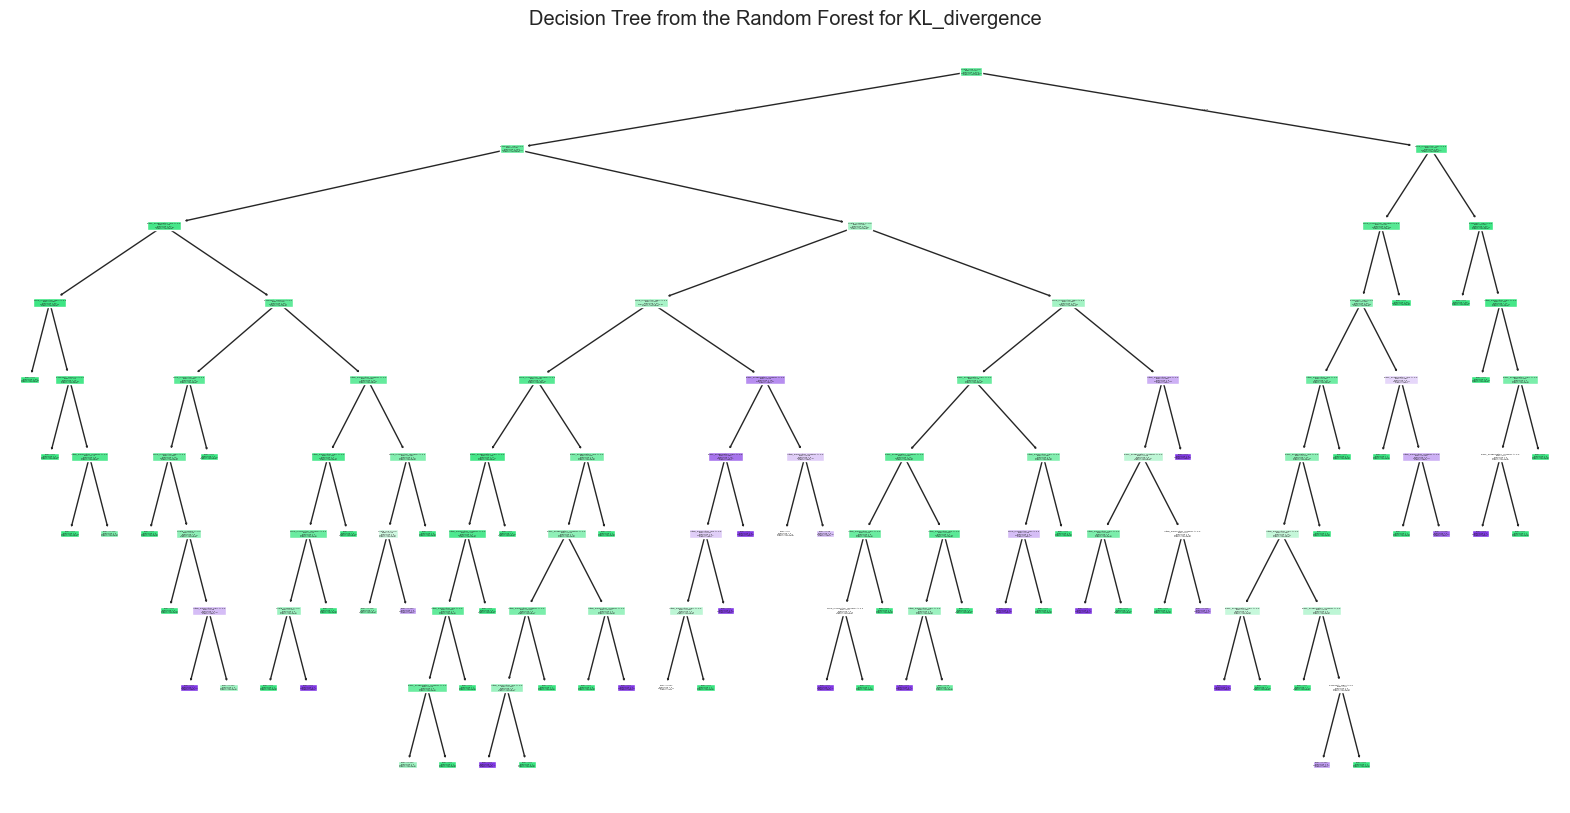

In [101]:
analyze_quality_with_random_forest_3bins(df_metrics, parameters, 'KL_divergence', n_tree=10)

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_quality_with_random_forest(df_input, parameters, quality_metric, n_tree=100, invert=False):
    # Convert the continuous quality metric into discrete categories
    df = df_input
    if invert:
        df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['high', 'medium', 'low'])
    else:
        df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
    # Define features and labels
    X = df[parameters]
    y = df['quality']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_tree, random_state=42)
    clf.fit(X_train, y_train)

    # Get model parameters
    print("Parameters:", clf.get_params())
    
    # Model evaluation
    y_pred = clf.predict(X_test)
    print(f"Classification report for {quality_metric}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {quality_metric}')
    plt.show()
    
    # Extract and print the decision rules from one tree in the forest
    print(f"Decision rules from the tree in the Random Forest for {quality_metric}:\n")
    for tree in clf.estimators_:
        tree_rules = export_text(tree, feature_names=list(parameters)).split('\n')
        for rule in tree_rules:
            print(rule)

    # Extract sample size for each tree
    for idx, _ in enumerate(clf.estimators_):
         print(f"Number of samples in root node of tree {idx}:, {clf.estimators_[idx].tree_.n_node_samples[0]}")
    
    return clf

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Classification report for KL_divergence:

              precision    recall  f1-score   support

        high       0.80      1.00      0.89        32
         low       0.96      0.96      0.96        28
      medium       0.97      0.77      0.86        39

    accuracy                           0.90        99
   macro avg       0.91      0.91      0.90        99
weighted avg       0.91      0.90      0.90        99



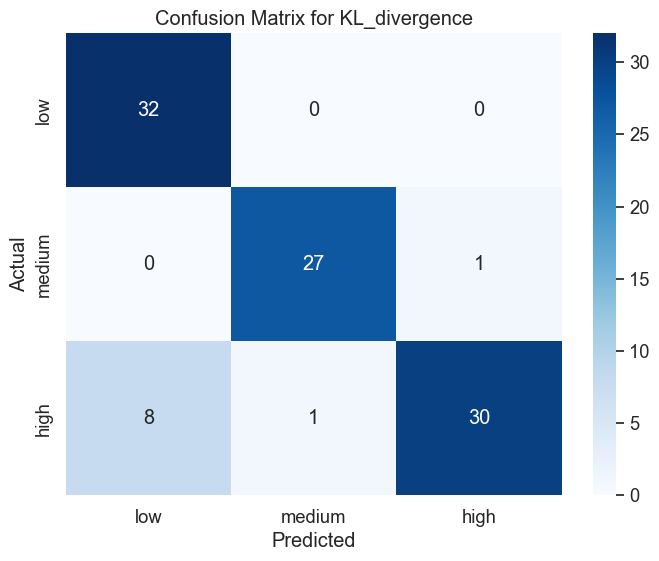

Decision rules from the tree in the Random Forest for KL_divergence:

|--- Perplexity <= 83.59
|   |--- Theta <= 0.20
|   |   |--- Theta <= 0.11
|   |   |   |--- class: 2.0
|   |   |--- Theta >  0.11
|   |   |   |--- class: 0.0
|   |--- Theta >  0.20
|   |   |--- Perplexity <= 31.20
|   |   |   |--- class: 0.0
|   |   |--- Perplexity >  31.20
|   |   |   |--- Initial_momentum <= 0.35
|   |   |   |   |--- Early_exaggeration <= 12.12
|   |   |   |   |   |--- Final_momentum <= 0.94
|   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |--- Final_momentum >  0.94
|   |   |   |   |   |   |--- Early_exaggeration <= 9.18
|   |   |   |   |   |   |   |--- Early_exaggeration <= 8.71
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Early_exaggeration >  8.71
|   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |--- Early_exaggeration >  9.18
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Early_exaggeration >  12.12
|   |  

In [143]:
clf = analyze_quality_with_random_forest(df_metrics, parameters, 'KL_divergence', n_tree=3, invert=False)

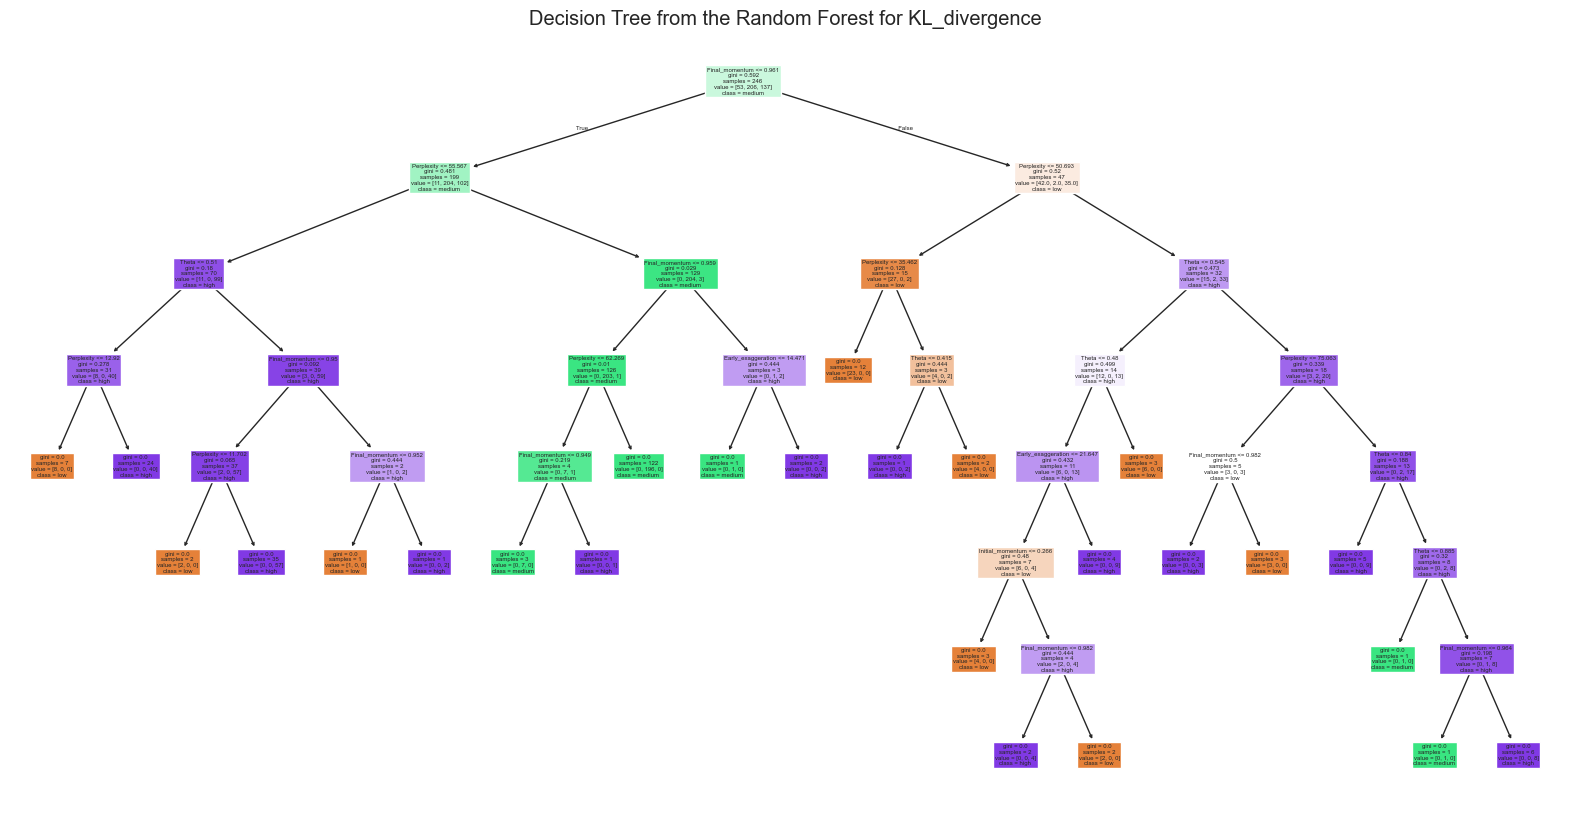

In [161]:
# Define class labels based on the invert parameter
invert = False
if invert:
    class_labels = ['high', 'medium', 'low']
else:
    class_labels = ['low', 'medium', 'high']

# Plot the decision tree
quality_metric = 'KL_divergence'
tree_idx = 2  # Choose the index of the tree to plot
tree = clf.estimators_[tree_idx-1]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=parameters, class_names=class_labels, filled=True)
plt.title(f'Decision Tree from the Random Forest for {quality_metric}')
plt.show()


In [133]:
# Assuming clf is your trained RandomForestClassifier
tree_idx = 1  # Index of the tree you want to inspect
node_idx = 36  # Index of the node within the tree

# Access the first tree in the forest
tree = clf.estimators_[tree_idx-1].tree_

# Get Gini impurity of the specified node
gini_impurity = tree.impurity[node_idx]

# Print the Gini impurity of the node
print(f"Gini impurity of node {node_idx} in tree {tree_idx}: {gini_impurity}")

# Optionally, print other related information
num_samples = tree.n_node_samples[node_idx]
print(f"Number of samples at this node: {num_samples}")

# Print left and right children of the node (if they exist)
left_child = tree.children_left[node_idx]
right_child = tree.children_right[node_idx]
print(f"Left child index: {left_child}, Right child index: {right_child}")


Gini impurity of node 36 in tree 3: 0.39014332071389946
Number of samples at this node: 110
Left child index: 37, Right child index: 40


Bootstrap enabled: True
Classification report for KL_divergence:

              precision    recall  f1-score   support

        high       0.80      1.00      0.89        32
         low       0.96      0.96      0.96        28
      medium       0.97      0.77      0.86        39

    accuracy                           0.90        99
   macro avg       0.91      0.91      0.90        99
weighted avg       0.91      0.90      0.90        99



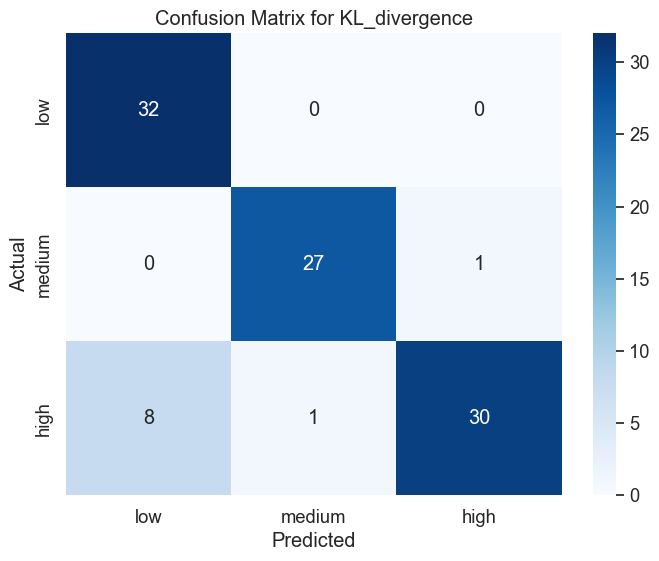

Decision rules from one tree in the Random Forest for KL_divergence:

|--- Perplexity <= 83.59
|   |--- Theta <= 0.20
|   |   |--- Theta <= 0.11
|   |   |   |--- class: 2.0
|   |   |--- Theta >  0.11
|   |   |   |--- class: 0.0
|   |--- Theta >  0.20
|   |   |--- Perplexity <= 31.20
|   |   |   |--- class: 0.0
|   |   |--- Perplexity >  31.20
|   |   |   |--- Initial_momentum <= 0.35
|   |   |   |   |--- Early_exaggeration <= 12.12
|   |   |   |   |   |--- Final_momentum <= 0.94
|   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |--- Final_momentum >  0.94
|   |   |   |   |   |   |--- Early_exaggeration <= 9.18
|   |   |   |   |   |   |   |--- Early_exaggeration <= 8.71
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- Early_exaggeration >  8.71
|   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |--- Early_exaggeration >  9.18
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Early_exaggeration >  12.12
|   |  

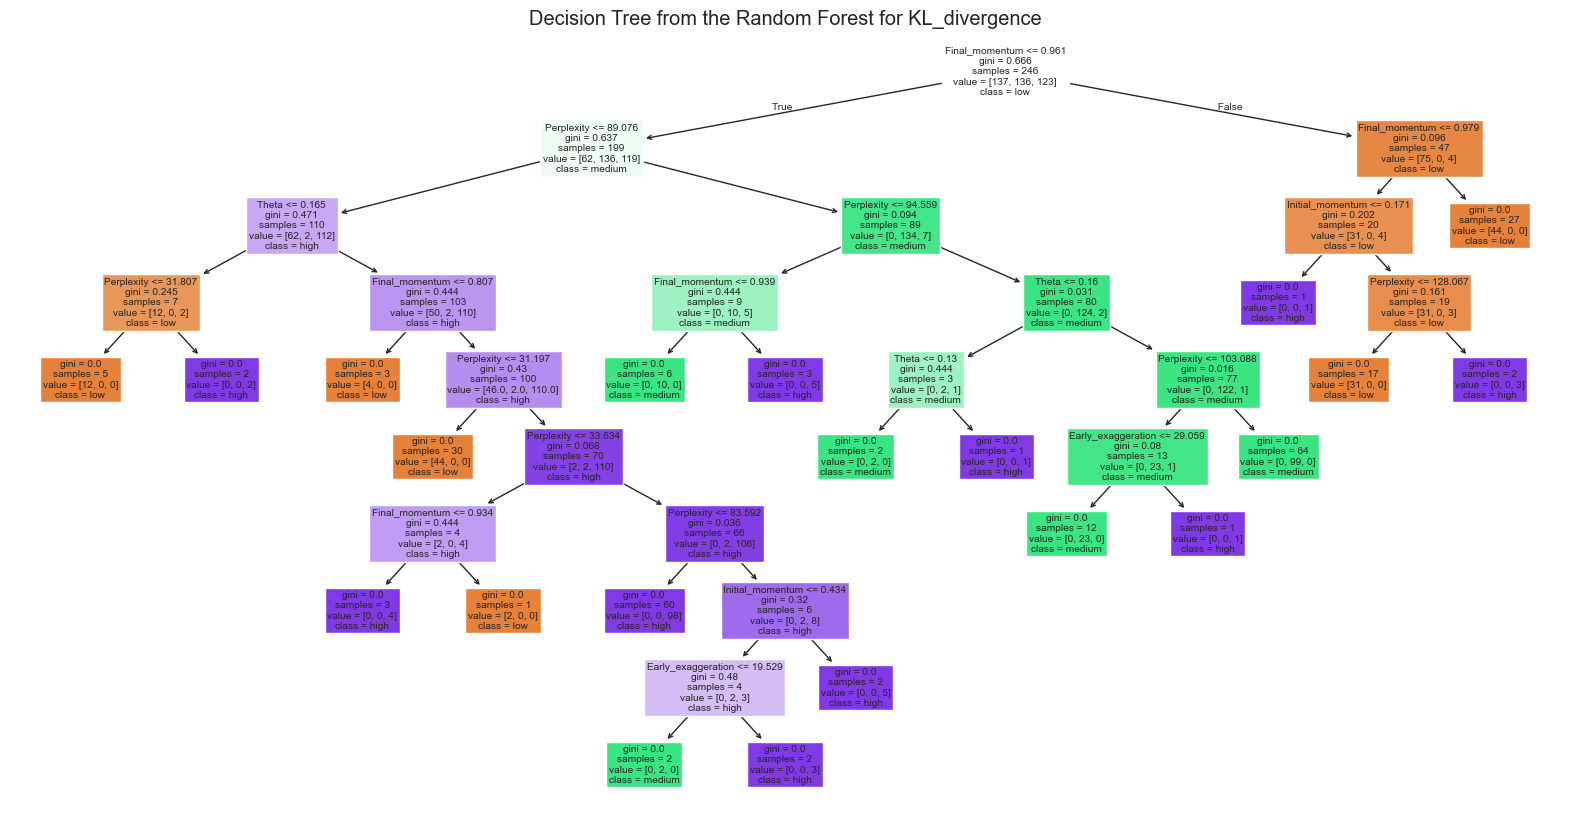

In [112]:
analyze_quality_with_random_forest(df_metrics, parameters, 'KL_divergence', n_tree=3)

In [42]:
for param in parameters:
    print(f'range of {param} is (: {min(df_metrics[param])}, {max(df_metrics[param])})')

range of Perplexity is (: 5.0, 150.0)
range of Early_exaggeration is (: 4.0, 32.0)
range of Initial_momentum is (: 0.1, 0.5)
range of Final_momentum is (: 0.8, 1.0)
range of Theta is (: 0.1, 1.0)


In [107]:
print(100*sum(df_metrics['Final_momentum'] <= 0.965)/495)
print(100*sum(df_metrics['Initial_momentum'] <= 0.14)/495)
print(100*sum(df_metrics['Theta'] <= 0.98)/495)
print(100*sum(df_metrics['Early_exaggeration'] > 17)/495)

82.82828282828282
9.090909090909092
97.57575757575758
51.313131313131315


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def analyze_quality_with_random_forest(df, parameters, quality_metric, n_tree=100):
    # Convert the continuous quality metric into discrete categories
    df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
    # Define features and labels
    X = df[parameters]
    y = df['quality']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_tree, random_state=42)
    clf.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = clf.predict(X_test)
    print(f"Classification report for {quality_metric}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {quality_metric}')
    plt.show()
    
    # Feature usage across all trees
    feature_usage = Counter()

    for tree in clf.estimators_:
        tree_rules = export_text(tree, feature_names=list(parameters)).split('\n')
        for rule in tree_rules:
            print(rule)
            #if 'feature_' in rule:
                # Properly parse the rule to extract the feature name
                #feature_name = rule.strip().split()[1]
                #feature_usage[feature_name] += 1
    
    
    # Plot the same decision tree
    #tree = clf.estimators_[0]  # Select the first tree for plotting
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=parameters, class_names=['low', 'medium', 'high'], filled=True)
    plt.title(f'Decision Tree from the Random Forest for {quality_metric}')
    plt.show()

    # Feature Importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure()
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X.shape[1]), [parameters[i] for i in indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()


# Example usage:
# df = pd.read_csv('your_dataset.csv')
# analyze_quality_with_random_forest(df, parameters=['feature1', 'feature2', 'feature3'], quality_metric='target_column')

    

In [ ]:
analyze_quality_with_random_forest(df_metrics, parameters, quality_metric, n_tree=100)

In [96]:
df_metrics.isnull().sum()

Combination           0
Perplexity            0
Early_exaggeration    0
Initial_momentum      0
Final_momentum        0
Theta                 0
tSNE_runtime_min      0
KL_divergence         0
trust_k30             0
trust_k300            0
stress                0
quality               0
dtype: int64

In [97]:
df_metrics.columns

Index(['Combination', 'Perplexity', 'Early_exaggeration', 'Initial_momentum',
       'Final_momentum', 'Theta', 'tSNE_runtime_min', 'KL_divergence',
       'trust_k30', 'trust_k300', 'stress', 'quality'],
      dtype='object')

In [142]:
param = 'KL_divergence'
quantiles = df_metrics[param].quantile([0, 1/3, 2/3, 1])
print(quantiles)
print(f'range of {param} is (: {min(df_metrics[param])}, {max(df_metrics[param])})')


0.000000    2.018198
0.333333    2.294290
0.666667    2.716997
1.000000    4.944373
Name: KL_divergence, dtype: float64
range of KL_divergence is (: 2.0181980947145064, 4.94437279657866)


Classification report for trust_k30:

              precision    recall  f1-score   support

        high       0.91      0.89      0.90        36
         low       0.91      0.86      0.88        35
      medium       0.71      0.79      0.75        28

    accuracy                           0.85        99
   macro avg       0.84      0.84      0.84        99
weighted avg       0.85      0.85      0.85        99



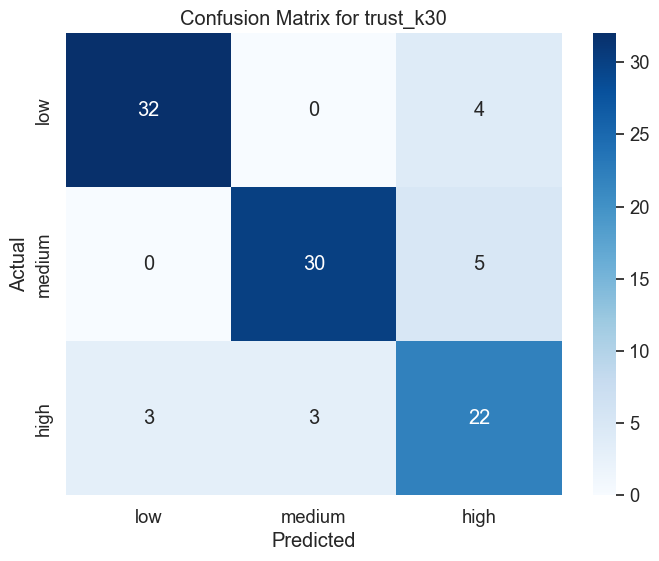

Decision rules from one tree in the Random Forest for trust_k30:

|--- Perplexity <= 60.44
|   |--- Theta <= 0.20
|   |   |--- Initial_momentum <= 0.40
|   |   |   |--- Final_momentum <= 0.96
|   |   |   |   |--- class: 0.0
|   |   |   |--- Final_momentum >  0.96
|   |   |   |   |--- class: 1.0
|   |   |--- Initial_momentum >  0.40
|   |   |   |--- class: 2.0
|   |--- Theta >  0.20
|   |   |--- Initial_momentum <= 0.35
|   |   |   |--- Early_exaggeration <= 27.88
|   |   |   |   |--- Final_momentum <= 0.96
|   |   |   |   |   |--- Initial_momentum <= 0.27
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Initial_momentum >  0.27
|   |   |   |   |   |   |--- Early_exaggeration <= 14.12
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Early_exaggeration >  14.12
|   |   |   |   |   |   |   |--- Initial_momentum <= 0.29
|   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |--- Initial_momentum >  0.29
|   |   |   |   |   |   | 

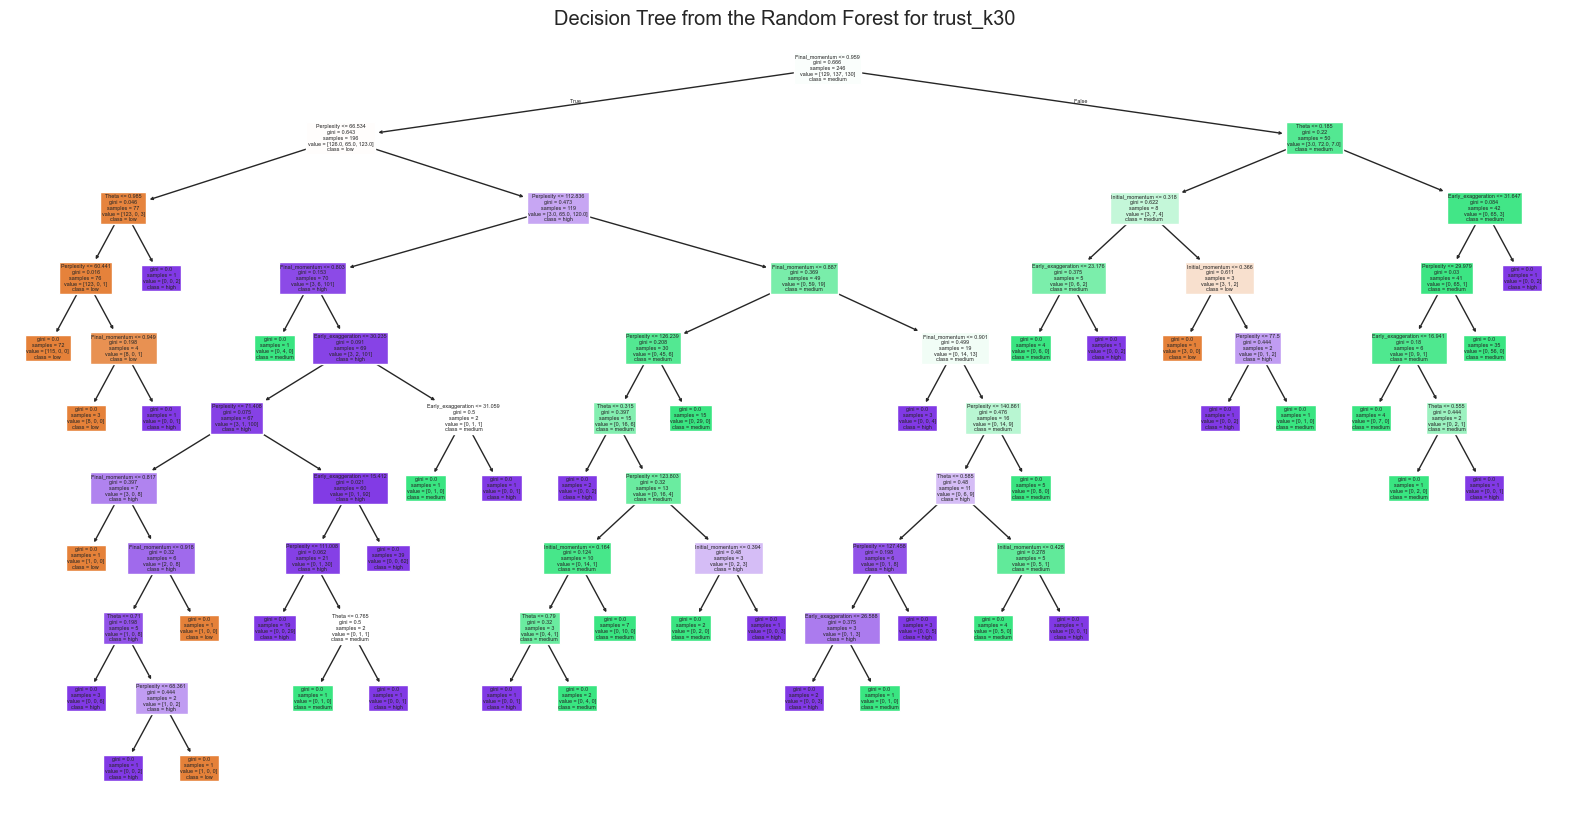

In [110]:
analyze_quality_with_random_forest(df_metrics, parameters, 'trust_k30', n_tree=3)

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def RF_custom(df_input, parameters, quality_metric, n_tree=100, invert=False, custom=False, cutoff=None):
    # Convert the continuous quality metric into discrete categories
    df = df_input
    
    if custom:
        # Compute quantiles and custom cut points
        min_val = df[quality_metric].min()
        peak = df[quality_metric].quantile(0.5)
        if cutoff is None:
            cutoff = df[quality_metric].quantile(0.75)  # Default cutoff at 75th percentile
        
        # Define bins for custom binning
        bins = [min_val, peak, cutoff, df[quality_metric].max()]
        labels = ['low', 'medium', 'high']
        
        # Apply custom binning
        df['quality'] = pd.cut(df[quality_metric], bins=bins, labels=labels, include_lowest=True)
    else:
        # Default binning using pd.qcut
        if invert:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['high', 'medium', 'low'])
        else:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
    # Define features and labels
    X = df[parameters]
    y = df['quality']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_tree, random_state=42, min_samples_leaf=7)
    clf.fit(X_train, y_train)

    # Get model parameters
    print("Parameters:", clf.get_params())
    
    # Model evaluation
    y_pred = clf.predict(X_test)
    print(f"Classification report for {quality_metric}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {quality_metric}')
    plt.show()
    
    # Extract and print the decision rules from one tree in the forest
    print(f"Decision rules from the tree in the Random Forest for {quality_metric}:\n")
    for tree in clf.estimators_:
        tree_rules = export_text(tree, feature_names=list(parameters)).split('\n')
        for rule in tree_rules:
            print(rule)

    # Extract sample size for each tree
    for idx, _ in enumerate(clf.estimators_):
        print(f"Number of samples in root node of tree {idx}: {clf.estimators_[idx].tree_.n_node_samples[0]}")
    
    return clf


Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Classification report for KL_divergence:

              precision    recall  f1-score   support

        high       1.00      0.89      0.94        18
         low       0.98      0.96      0.97        47
      medium       0.89      0.97      0.93        34

    accuracy                           0.95        99
   macro avg       0.96      0.94      0.95        99
weighted avg       0.95      0.95      0.95        99



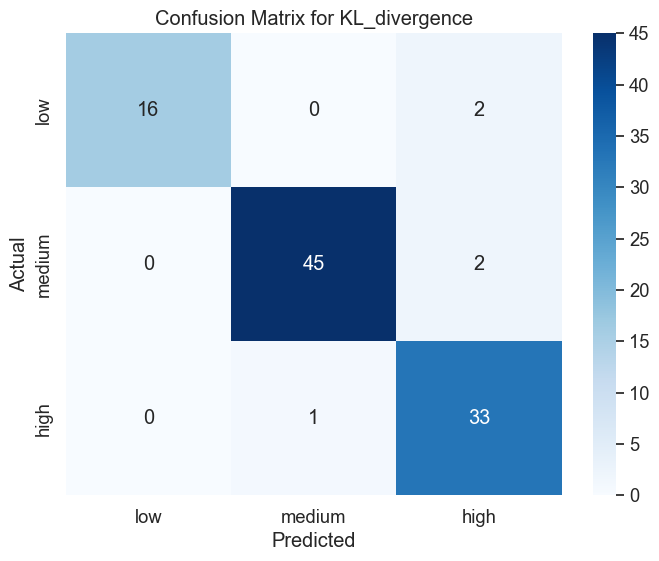

Decision rules from the tree in the Random Forest for KL_divergence:

|--- Perplexity <= 59.22
|   |--- Early_exaggeration <= 27.88
|   |   |--- Theta <= 0.55
|   |   |   |--- Perplexity <= 14.14
|   |   |   |   |--- class: 0.0
|   |   |   |--- Perplexity >  14.14
|   |   |   |   |--- Initial_momentum <= 0.34
|   |   |   |   |   |--- Early_exaggeration <= 20.82
|   |   |   |   |   |   |--- Final_momentum <= 0.95
|   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |--- Final_momentum >  0.95
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Early_exaggeration >  20.82
|   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- Initial_momentum >  0.34
|   |   |   |   |   |--- class: 2.0
|   |   |--- Theta >  0.55
|   |   |   |--- Early_exaggeration <= 10.12
|   |   |   |   |--- class: 2.0
|   |   |   |--- Early_exaggeration >  10.12
|   |   |   |   |--- Early_exaggeration <= 25.18
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- Early_exaggera

In [167]:
clf = RF_custom(df_metrics, parameters, 'KL_divergence', n_tree=10, invert=False, custom=True, cutoff=3)

In [168]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def evaluate_rf_cross_validation(clf, df_input, parameters, quality_metric, invert = False, custom = False, n_splits=5, cutoff=None):
    """
    Evaluate a trained RandomForestClassifier using cross-validation.
    
    Parameters:
    - clf: Trained RandomForestClassifier object.
    - X: Features (data).
    - y: Target variable.
    - n_splits: Number of folds for cross-validation (default is 5).
    
    Returns:
    - None: Prints cross-validation results.
    """
    
    df = df_input
    
    if custom:
        # Compute quantiles and custom cut points
        min_val = df[quality_metric].min()
        peak = df[quality_metric].quantile(0.5)
        if cutoff is None:
            cutoff = df[quality_metric].quantile(0.75)  # Default cutoff at 75th percentile
        
        # Define bins for custom binning
        bins = [min_val, peak, cutoff, df[quality_metric].max()]
        labels = ['low', 'medium', 'high']
        
        # Apply custom binning
        df['quality'] = pd.cut(df[quality_metric], bins=bins, labels=labels, include_lowest=True)
    else:
        # Default binning using pd.qcut
        if invert:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['high', 'medium', 'low'])
        else:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
    # Define features and labels
    X = df[parameters]
    y = df['quality']
    
    # Define KFold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores)}")
    print(f"Standard Deviation of Accuracy: {np.std(scores)}")

# Assuming clf is your trained RandomForestClassifier, and X, y are your features and target.
# evaluate_rf_cross_validation(clf, X, y)


In [169]:
evaluate_rf_cross_validation(clf, df_metrics, parameters, 'KL_divergence', invert = False, custom = True, n_splits=5, cutoff=3)


Cross-Validation Scores: [0.95959596 0.94949495 0.93939394 0.92929293 0.97979798]
Mean Accuracy: 0.9515151515151515
Standard Deviation of Accuracy: 0.017378434882914382


In [170]:
# Assuming clf is your trained RandomForestClassifier
tree_idx = 1  # Index of the tree you want to inspect
node_idx = 36  # Index of the node within the tree

# Access the first tree in the forest
tree = clf.estimators_[tree_idx-1].tree_

# Get Gini impurity of the specified node
gini_impurity = tree.impurity[node_idx]

# Print the Gini impurity of the node
print(f"Gini impurity of node {node_idx} in tree {tree_idx}: {gini_impurity}")

# Optionally, print other related information
num_samples = tree.n_node_samples[node_idx]
print(f"Number of samples at this node: {num_samples}")

# Print left and right children of the node (if they exist)
left_child = tree.children_left[node_idx]
right_child = tree.children_right[node_idx]
print(f"Left child index: {left_child}, Right child index: {right_child}")


IndexError: index 36 is out of bounds for axis 0 with size 33

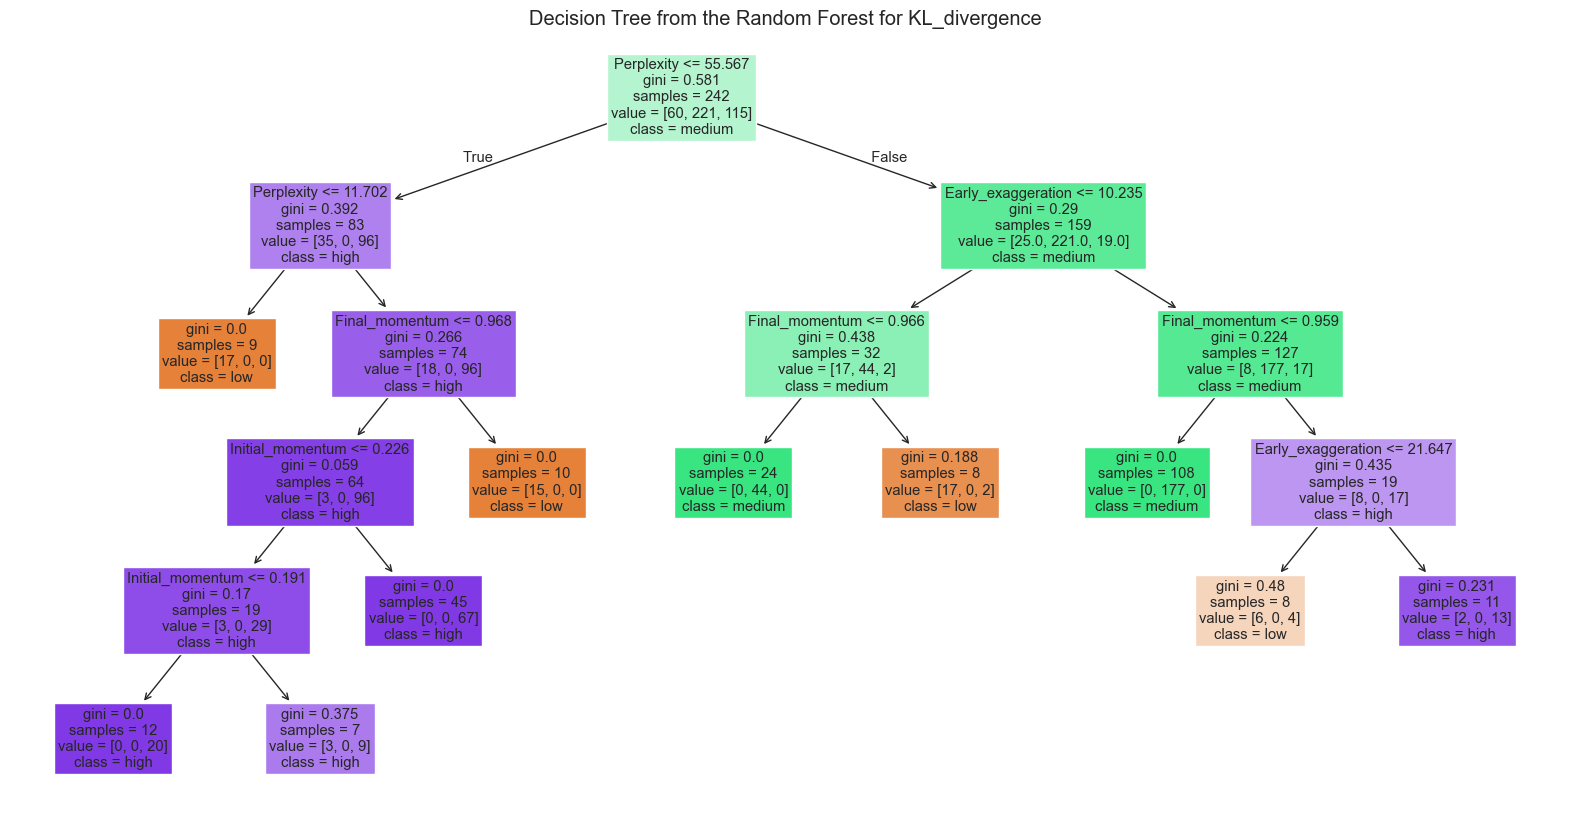

In [181]:
# Define class labels based on the invert parameter
invert = False
if invert:
    class_labels = ['high', 'medium', 'low']
else:
    class_labels = ['low', 'medium', 'high']

# Plot the decision tree
quality_metric = 'KL_divergence'
tree_idx = 10  # Choose the index of the tree to plot
tree = clf.estimators_[tree_idx-1]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=parameters, class_names=class_labels, filled=True)
plt.title(f'Decision Tree from the Random Forest for {quality_metric}')
plt.show()


In [182]:
import pandas as pd

def print_bin_percentages(df, column, cutoff1, cutoff2):
    """
    Print the percentages of samples in each bin defined by custom cutoffs.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - column: The column to be binned.
    - cutoff1: The cutoff value for the first bin boundary.
    - cutoff2: The cutoff value for the second bin boundary.
    """
    # Define bin edges and labels
    bin_edges = [df[column].min(), cutoff1, cutoff2, df[column].max()]
    bin_labels = [f'({bin_edges[0]:.2f}, {cutoff1:.2f}]', f'({cutoff1:.2f}, {cutoff2:.2f}]', f'({cutoff2:.2f}, {bin_edges[2]:.2f}]']
    
    # Apply custom binning
    df['binned'] = pd.cut(df[column], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
    # Calculate and print percentages
    bin_counts = df['binned'].value_counts(normalize=True) * 100
    print(f"Bin Percentages for column '{column}':")
    for label in bin_labels:
        percentage = bin_counts.get(label, 0)
        print(f"{label}: {percentage:.2f}%")

# Example usage:
# df_metrics = your DataFrame
# print_bin_percentages(df_metrics, 'T(30)', cutoff1=0.56, cutoff2=0.57)


In [184]:
df_metrics.columns

Index(['Combination', 'Perplexity', 'Early_exaggeration', 'Initial_momentum',
       'Final_momentum', 'Theta', 'tSNE_runtime_min', 'KL_divergence',
       'trust_k30', 'trust_k300', 'stress', 'quality'],
      dtype='object')

In [185]:
print_bin_percentages(df_metrics, 'trust_k30', cutoff1=0.56, cutoff2=0.57)

Bin Percentages for column 'trust_k30':
(0.53, 0.56]: 20.61%
(0.56, 0.57]: 45.86%
(0.57, 0.57]: 33.54%


In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from matplotlib import gridspec

def RF_custom_2cuts(df_input, parameters, quality_metric, n_tree=100, invert=False, custom=False, cutoff1=None, cutoff2=None):
    """
    Train and evaluate a Random Forest Classifier on a dataset with a custom or default binning scheme.

    Parameters:
    - df_input: DataFrame containing the input data.
    - parameters: List of feature column names.
    - quality_metric: Column name of the target variable to be binned.
    - n_tree: Number of trees in the Random Forest.
    - invert: Whether to invert the labels for the default binning.
    - custom: Whether to use custom binning.
    - cutoff1: First cutoff value for custom binning (if custom=True).
    - cutoff2: Second cutoff value for custom binning (if custom=True).

    Returns:
    - Trained RandomForestClassifier object.
    """

    # Copy the input DataFrame to avoid modifying the original data
    df = df_input
    
    if custom:
        # Compute custom binning
        min_val = df[quality_metric].min()
        max_val = df[quality_metric].max()
        
        # Set default cutoffs if not provided
        if cutoff1 is None:
            cutoff1 = df[quality_metric].quantile(0.33)
        if cutoff2 is None:
            cutoff2 = df[quality_metric].quantile(0.67)
        
        # Define bins and labels
        bins = [min_val, cutoff1, cutoff2, max_val]
        labels = ['low', 'medium', 'high']
        
        # Apply custom binning
        df['quality'] = pd.cut(df[quality_metric], bins=bins, labels=labels, include_lowest=True)
    else:
        # Default binning using pd.qcut
        if invert:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['high', 'medium', 'low'])
        else:
            df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
    # Define features and labels
    X = df[parameters]
    y = df['quality']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_tree, random_state=42, min_samples_leaf=7)
    clf.fit(X_train, y_train)

    # Get model parameters
    print("Parameters:", clf.get_params())
    
    # Model evaluation
    y_pred = clf.predict(X_test)
    print(f"Classification report for {quality_metric}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {quality_metric}')
    plt.show()
    
    # Extract and print the decision rules from one tree in the forest
    print(f"Decision rules from the tree in the Random Forest for {quality_metric}:\n")
    for tree in clf.estimators_:
        tree_rules = export_text(tree, feature_names=list(parameters)).split('\n')
        for rule in tree_rules:
            print(rule)

    # Extract sample size for each tree
    for idx, _ in enumerate(clf.estimators_):
        print(f"Number of samples in root node of tree {idx}: {clf.estimators_[idx].tree_.n_node_samples[0]}")

    # Compute SHAP values
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap_interaction = explainer.shap_interaction_values(X)

    fig = plt.figure(tight_layout=True, figsize=(20, 10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    # Main effect SHAP dependence plot
    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[1], X, display_features=X, interaction_index=f2, ax=ax0, show=False)
    ax0.set_title(f'SHAP main effect of {f1}', fontsize=10)

    # Interaction SHAP dependence plot
    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X, display_features=X, ax=ax1, axis_color='w', show=False)
    ax1.set_title(f'SHAP interaction effect of {f1} and {f2}', fontsize=10)
    
    return clf


Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Classification report for trust_k30:

              precision    recall  f1-score   support

        high       1.00      0.95      0.97        37
         low       0.90      0.76      0.83        25
      medium       0.81      0.95      0.88        37

    accuracy                           0.90        99
   macro avg       0.91      0.88      0.89        99
weighted avg       0.91      0.90      0.90        99



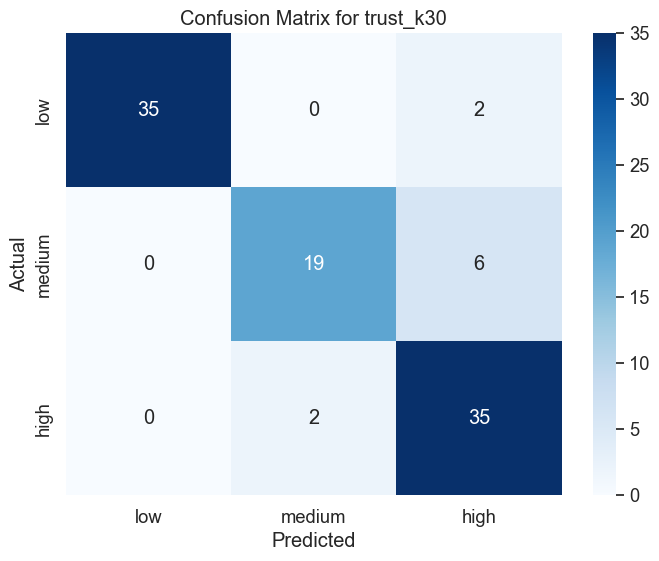

Decision rules from the tree in the Random Forest for trust_k30:

|--- Perplexity <= 60.44
|   |--- Theta <= 0.20
|   |   |--- class: 0.0
|   |--- Theta >  0.20
|   |   |--- Initial_momentum <= 0.35
|   |   |   |--- Final_momentum <= 0.96
|   |   |   |   |--- class: 0.0
|   |   |   |--- Final_momentum >  0.96
|   |   |   |   |--- Initial_momentum <= 0.28
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- Initial_momentum >  0.28
|   |   |   |   |   |--- class: 1.0
|   |   |--- Initial_momentum >  0.35
|   |   |   |--- Theta <= 0.34
|   |   |   |   |--- class: 0.0
|   |   |   |--- Theta >  0.34
|   |   |   |   |--- class: 0.0
|--- Perplexity >  60.44
|   |--- Final_momentum <= 0.96
|   |   |--- Early_exaggeration <= 8.82
|   |   |   |--- class: 2.0
|   |   |--- Early_exaggeration >  8.82
|   |   |   |--- Theta <= 0.85
|   |   |   |   |--- Perplexity <= 71.41
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- Perplexity >  71.41
|   |   |   |   |   |--- class: 2.0
|   |   |  

In [204]:
clf = RF_custom_2cuts(df_metrics, parameters, 'trust_k30', n_tree=10, invert=False, custom=True, cutoff1=0.56,cutoff2=0.57)

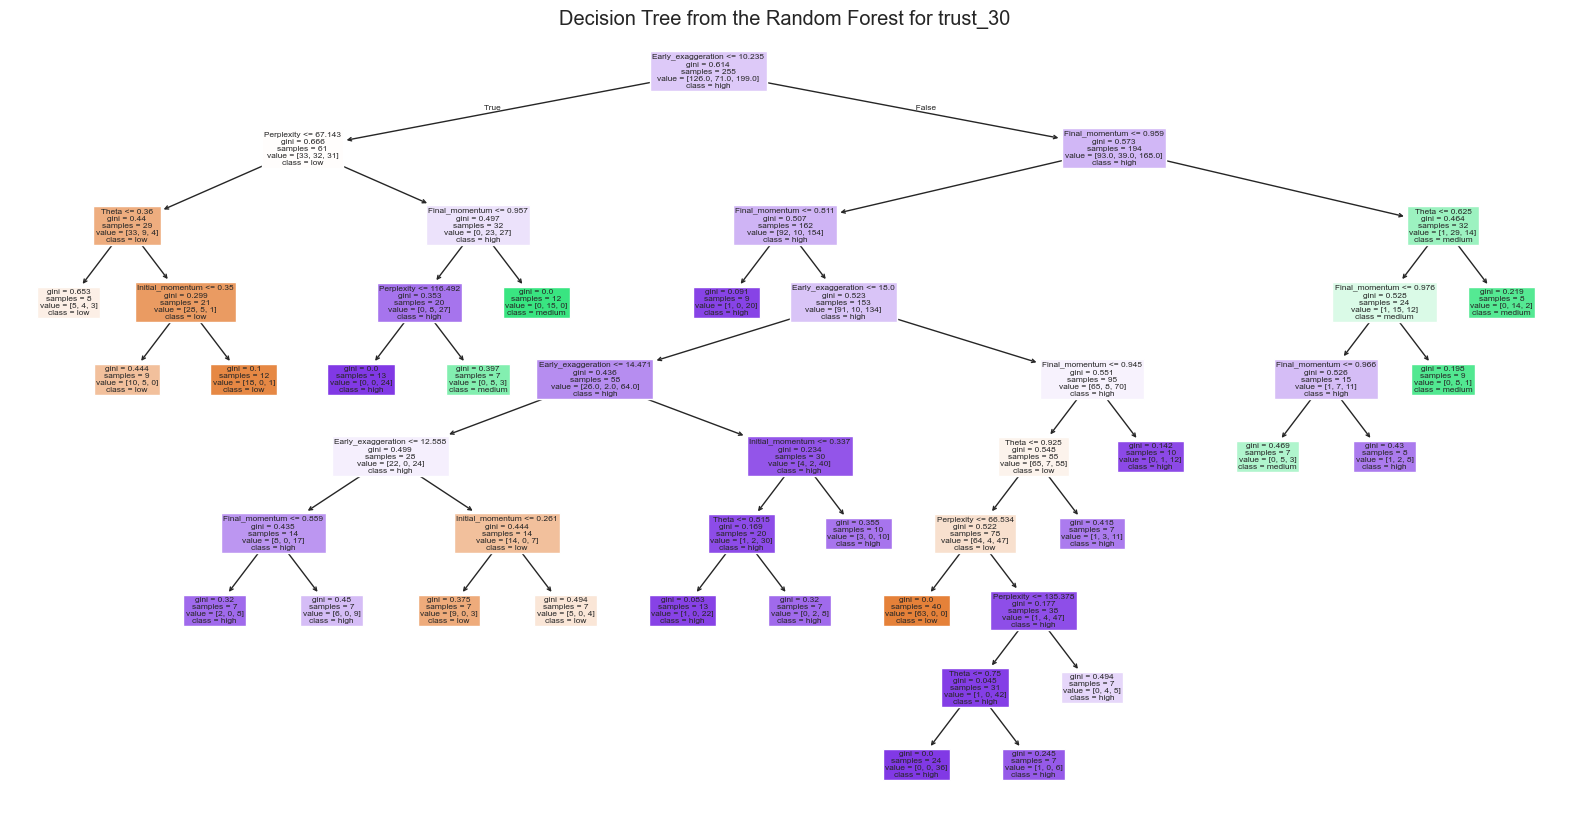

In [202]:
# Define class labels based on the invert parameter
invert = False
if invert:
    class_labels = ['high', 'medium', 'low']
else:
    class_labels = ['low', 'medium', 'high']

# Plot the decision tree
quality_metric = 'trust_30'
tree_idx = 7  # Choose the index of the tree to plot
tree = clf.estimators_[tree_idx-1]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=parameters, class_names=class_labels, filled=True)
plt.title(f'Decision Tree from the Random Forest for {quality_metric}')
plt.show()

In [242]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import gridspec

custom = True
cutoff1=0.56
cutoff2=0.57
df = df_metrics
quality_metric = 'trust_k30'

if custom:
    # Compute custom binning
    min_val = df[quality_metric].min()
    max_val = df[quality_metric].max()
        
    # Set default cutoffs if not provided
    if cutoff1 is None:
        cutoff1 = df[quality_metric].quantile(0.33)
    if cutoff2 is None:
        cutoff2 = df[quality_metric].quantile(0.67)
        
    # Define bins and labels
    bins = [min_val, cutoff1, cutoff2, max_val]
    labels = ['low', 'medium', 'high']
        
    # Apply custom binning
    df['quality'] = pd.cut(df[quality_metric], bins=bins, labels=labels, include_lowest=True)
else:
    # Default binning using pd.qcut
    if invert:
        df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['high', 'medium', 'low'])
    else:
        df['quality'] = pd.qcut(df[quality_metric], q=3, labels=['low', 'medium', 'high'])
    
# Define features and labels
X = df[parameters]
y = df['quality']
    
    # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

# Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap_interaction = explainer.shap_interaction_values(X)
print(np.shape(shap_interaction))
print(np.shape(shap_values))

(495, 5, 5, 3)
(495, 5, 3)


In [240]:
# Get absolute mean of matrices for class 0 (first in the 3D array mean_shap)
mean_shap = np.abs(shap_interaction).mean(0)
print(np.shape(mean_shap))
idx_class = 2
mean_class = mean_shap[:,:,idx_class]
df = pd.DataFrame(mean_class, index=X.columns, columns=X.columns)
#display(df.head())

# Set the diagonal elements to NaN to remove them from the heatmap
np.fill_diagonal(df.values, np.nan)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df, dtype=bool))

# Display the DataFrame (optional, to see the modifications)
#display(df)

# Elements not in diagonal (interactions themselves) by factor
factor = 1
df.where(df.values == np.diagonal(df),df.values*factor, inplace=True)
#display(df)

# display
display = False
if display== True: 
    fig = plt.figure(figsize=(10, 10)) #, #facecolor='#002637', edgecolor='r')
    ax = fig.add_subplot()
    sns.heatmap(df.round(decimals=3), mask=mask, cmap='coolwarm', annot=True, ax=ax, cbar_kws={'ticks': []}, linewidths=.5, linecolor='white')
    ax.tick_params(axis='x', colors='b', labelsize=15, rotation=90)
    ax.tick_params(axis='y', colors='b', labelsize=15)

    #plt.suptitle("SHAP interaction values", color="black", fontsize=6, y=0.97)
    plt.yticks(rotation=0) 
    plt.show()

(5, 5, 3)


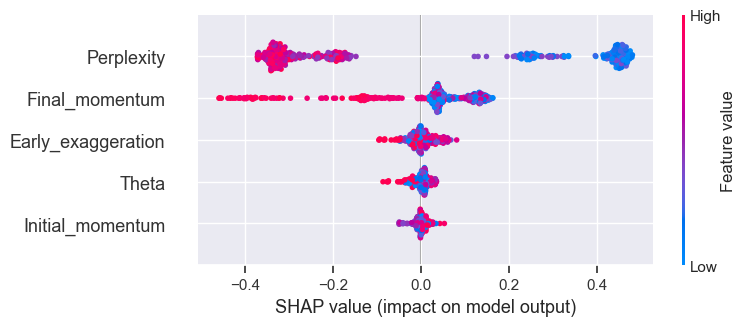

In [246]:
# Assuming you want to plot SHAP values for class_idx
class_idx = 0
shap_values_class_id = shap_values[:,:,class_idx]

# Generate SHAP summary plot for the chosen class
shap.summary_plot(shap_values_class_id, X)

trust_k30


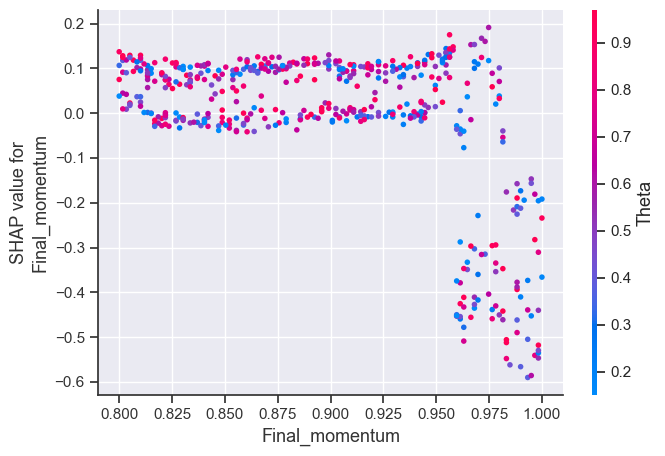

In [273]:
# Dependence plot for a specific feature
class_idx = 2
print(quality_metric)
shap.dependence_plot('Final_momentum', shap_values[:,:,class_idx], X, interaction_index='Theta')

In [ ]:
## Force plot for a specific instance
#shap.force_plot(explainer.expected_value, shap_values[instance_index], X.iloc[instance_index])

In [213]:
# Define the plotting function
def plot_feature_interaction(f1, f2, X, shap_values, shap_interaction, class_idx=1):
    fig = plt.figure(tight_layout=True, figsize=(20, 10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    # Main effect SHAP dependence plot
    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[class_idx-1], X, display_features=X, interaction_index=f2, ax=ax0, show=False)
    ax0.set_title(f'SHAP main effect of {f1}', fontsize=10)

    # Interaction SHAP dependence plot
    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X, display_features=X, ax=ax1, axis_color='w', show=False)
    ax1.set_title(f'SHAP interaction effect of {f1} and {f2}', fontsize=10)

In [207]:
parameters

['Perplexity',
 'Early_exaggeration',
 'Initial_momentum',
 'Final_momentum',
 'Theta']

AssertionError: 'shap_values' and 'features' values must have the same number of rows!

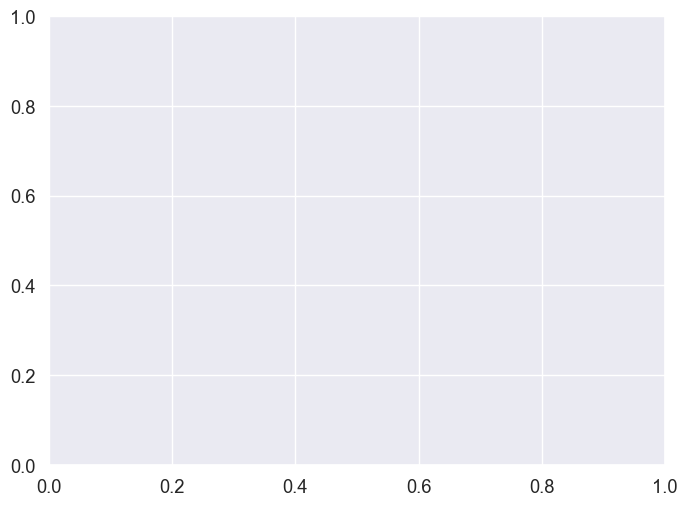

In [211]:
plot_feature_interaction('Perplexity', 'Early_exaggeration', X, shap_interaction, shap_values)